In [1]:
import numpy as np

In [32]:
class ConvLayer:
    def __init__(self, kernels, num_filters):
        self.kernels = kernels
        self.num_filters = num_filters
        # Our filters will be kernels * kernels * num_filters.
        self.filters = np.random.randn(num_filters, kernels, kernels) / 9
    
    def iterate_regions(self, image):
        """
        Generates all possible K x K image regions using vaild padding.
        - image is a 2d numpy array
        """
        height, width = image.shape
        for h in range(height-self.kernels+1):
            for w in range(width-self.kernels+1):
                yield image[h:h+self.kernels, w:w+self.kernels], h, w
    
    def forward(self, layer_input):
        """
        Performs a forward calculate of the conv layer using the given input.
        Returns a 3d numpy array with dimensions
        - imput is a 2D numpy array
        """
        # Only fit for the 2D input.
        height, width = layer_input.shape
        
        layer_output = np.zeros((height-self.kernels+1, width-self.kernels+1, self.num_filters))
        for image_region, h, w in self.iterate_regions(layer_input):
            layer_output[h,w] = np.sum(image_region * self.filters, axis=(1, 2))
        return layer_output

In [3]:
import mnist
import matplotlib.pyplot as plt
%matplotlib inline

ConvLayer input (28, 28)
(26, 26, 8)


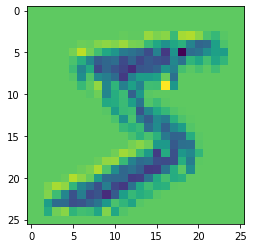

In [4]:
# The mnist package handles the MNIST dataset for us!
# Learn more at https://github.com/datapythonista/mnist
train_images = mnist.train_images()
train_labels = mnist.train_labels()
conv = ConvLayer(3, 8)
output = conv.forward(train_images[0])
print(output.shape)
plt.imshow(output[:,:, 0])

In [33]:
class MaxPoolLayer:
    def __init__(self, size=2):
        """
        Max pool layer default size is 2.
        """
        self.size = size
    
    def iterate_regions(self, image):
        height, width, _ = image.shape
        mid_h = height // self.size
        mid_w = width // self.size
        for h in range(mid_h):
            for w in range(mid_w):
                image_region = image[h*self.size : self.size*(h+1),
                                     w*self.size : self.size*(w+1)]
                yield image_region, h, w
    
    def forward(self, layer_input):
        height, width, filters = layer_input.shape
        layer_output = np.zeros((height//self.size, width//self.size, filters))
        for image_region, h, w in self.iterate_regions(layer_input):
            layer_output[h, w] = np.max(image_region, axis=(0,1))
        return layer_output

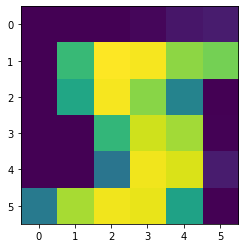

In [60]:
conv = ConvLayer(3, 8)
conv_output = conv.forward(train_images[0])
max_pool = MaxPoolLayer(4)
max_pool_output = max_pool.forward(conv_output)
max_pool_output.shape
plt.imshow(max_pool_output[:,:,1])

In [128]:
class Softmax:
    
    def __new__(self, nodes):
        self.biases = np.zeros(nodes)
        if not hasattr(self, "instance"):
            self.instance = super().__new__(self)
        return self.instance
    
    def cache_parameter(self, layer_input):
        self.last_input_shape = layer_input.shape
        if not hasattr(self, "weights"):
            w, h, d = layer_input.shape
            self.weights = np.random.randn(w * h * d, len(self.biases)) / (w * h * d)
        self.last_input = layer_input.flatten()
        self.last_totals = np.dot(self.last_input, self.weights) + self.biases
        return self.last_totals
    
    def forward(self, layer_input):
        totals = self.cache_parameter(layer_input)
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)


In [121]:
soft = Softmax(10)

In [122]:
out = soft.forward(max_pool_output)

(288, 10) (288,)


In [123]:
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

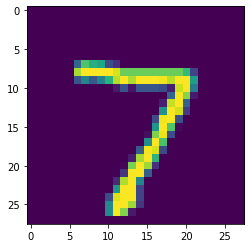

In [124]:
test_labels[0]
plt.imshow(test_images[0])

In [129]:
class Mode:
    def __init__(self, layer):
        self.layer = layer
    
    def forward(self, image, label):
        out = (image / 255) - 0.5
        for layer in self.layer:
            out = layer.forward(out)
        loss = -np.log(out[label]) # Cross-Entropy Loss
        acc = 1 if np.argmax(out) == label else 0
        
        return out, loss, acc

In [130]:
m = Mode([
    ConvLayer(3, 8),
    MaxPoolLayer(),
    Softmax(10)
])

In [131]:
loss = 0
num_correct = 0
for index, (image, label) in enumerate(zip(test_images, test_labels)):
    _, l, acc = m.forward(image, label)
    loss += l
    num_correct += acc
    
    if index % 100 == 99:
        print(
            '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
            (index + 1, loss / 100, num_correct)
        )
        loss = 0
        num_correct = 0

[Step 100] Past 100 steps: Average Loss 2.302 | Accuracy: 15%
[Step 200] Past 100 steps: Average Loss 2.303 | Accuracy: 7%
[Step 300] Past 100 steps: Average Loss 2.302 | Accuracy: 9%
[Step 400] Past 100 steps: Average Loss 2.303 | Accuracy: 11%
[Step 500] Past 100 steps: Average Loss 2.303 | Accuracy: 7%
[Step 600] Past 100 steps: Average Loss 2.302 | Accuracy: 8%
[Step 700] Past 100 steps: Average Loss 2.302 | Accuracy: 10%
[Step 800] Past 100 steps: Average Loss 2.303 | Accuracy: 8%
[Step 900] Past 100 steps: Average Loss 2.302 | Accuracy: 10%
[Step 1000] Past 100 steps: Average Loss 2.303 | Accuracy: 5%


Trainning  a neural network typically consists of two phases:
1. A `forward` phase, where the input is passed through the network to the last layer.
2. A `backword` phase, where the gradients are backpropagated and weights and biases on each layers upadates.

In [45]:
b = np.array([2,1])
b.shape

(2,)

In [48]:
b[np.newaxis].shape

(1, 2)